In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from collections import Counter
from plotly import express as ex

%matplotlib inline

In [2]:
PATH = "."

In [3]:
train = pd.read_csv(f"{PATH}/data.csv")

In [4]:
train.head()

filename  width  height class  xmin  ymin  xmax  \
0  ./JPEGImages/BloodImage_00266.jpg    640     480   RBC   509   147   621   
1  ./JPEGImages/BloodImage_00266.jpg    640     480   RBC   444   146   514   
2  ./JPEGImages/BloodImage_00266.jpg    640     480   RBC   345   219   457   
3  ./JPEGImages/BloodImage_00266.jpg    640     480   RBC   287   340   407   
4  ./JPEGImages/BloodImage_00266.jpg    640     480   RBC     1   154    86   

   ymax  
0   254  
1   258  
2   328  
3   445  
4   245

In [5]:
train['xmin'],train['xmax'] = train['xmin'] / 640,train['xmax'] / 640
train['ymin'],train['ymax'] = train['ymin'] / 480,train['ymax'] / 480

In [6]:
train['h'] = train.ymax - train.ymin
train['w'] = train.xmax - train.xmin

train['y'] = train.ymin + (train.h / 2)
train['x'] = train.xmin + (train.w / 2)

In [7]:
train.head(2)

filename  width  height class      xmin      ymin  \
0  ./JPEGImages/BloodImage_00266.jpg    640     480   RBC  0.795312  0.306250   
1  ./JPEGImages/BloodImage_00266.jpg    640     480   RBC  0.693750  0.304167   

       xmax      ymax         h         w         y         x  
0  0.970313  0.529167  0.222917  0.175000  0.417708  0.882812  
1  0.803125  0.537500  0.233333  0.109375  0.420833  0.748437

In [11]:
class JSON(object):
    """
    Helper Class For Mapping JSON vars to Objects
    """
    def __init__(self,data=dict(),inner=False):
        for key in data:
            if type(data[key]) == dict:
                self.__dict__[key] = JSON(data[key],inner=True)
            else:
                self.__dict__[key] = data[key]

    def __repr__(self):
        return self.__dict__.__str__()
    
    def __str__(self):
        return self.__dict__.__str__()
    
    def __getitem__(self,key):
        return self.__dict__[key]
    
    def __setitem__(self,key,value):
        self.__dict__[key] = value
    
    def __iter__(self):
        for key in self.__dict__:
            if type(self.__dict__[key]) == JSON:
                yield key, self.__dict__[key]()
            else:
                yield key, self.__dict__[key]
        
    def __call__(self,):
        return {i:j for i,j in  self.__iter__()}

In [12]:
train['class'].unique()

array(['RBC', 'WBC', 'Platelets'], dtype=object)

In [13]:
data = []
grouped = train.groupby(by='filename')

for i in train.filename.unique():
    group = grouped.get_group(i)[['class','xmin','ymin','xmax','ymax','x','y','h','w']]
#     group = group[group['class']]#.query('h > 0.4 and w > 0.3')
    group = group.T.to_dict().values()
    boxes = [JSON(i) for i in group]
    if len(boxes):
        data.append(JSON({
            'filename':i,
            'boxes':boxes
        }))

In [56]:
len(data)

364

In [15]:
IMG_SIZE = 384

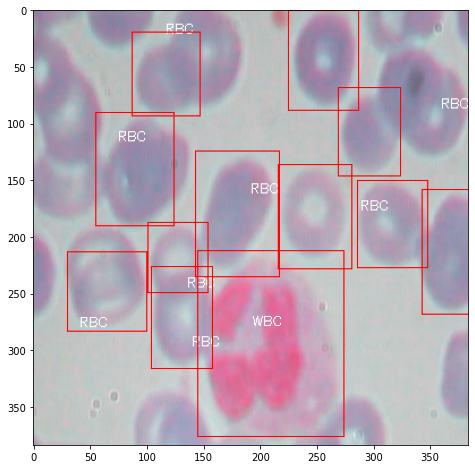

In [16]:
image = data[np.random.randint(len(data))]

img = cv2.imread(image['filename'])
img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

for box in image['boxes']:
    img = cv2.putText(img,box['class'],(int(box['xmin']*512),int(box['ymin']*512)-5),cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255))
    img = cv2.rectangle(
            img,
            (int(box.xmin*IMG_SIZE),int(box.ymin*IMG_SIZE)),
            (int(box.xmax*IMG_SIZE),int(box.ymax*IMG_SIZE)),
            (255,0,0),
            1
        )

plt.figure(figsize=(12,8))
plt.imshow(img)

In [17]:
images = np.array([cv2.resize(cv2.imread(i['filename']),(IMG_SIZE,IMG_SIZE)) for i in data])

In [18]:
images = images.astype(np.float32) / 255

In [19]:
hw = ((train[['h','w']].copy()*IMG_SIZE).astype(np.uint16) / 64)*64

In [20]:
ex.scatter(data_frame=hw,x='w',y='h')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


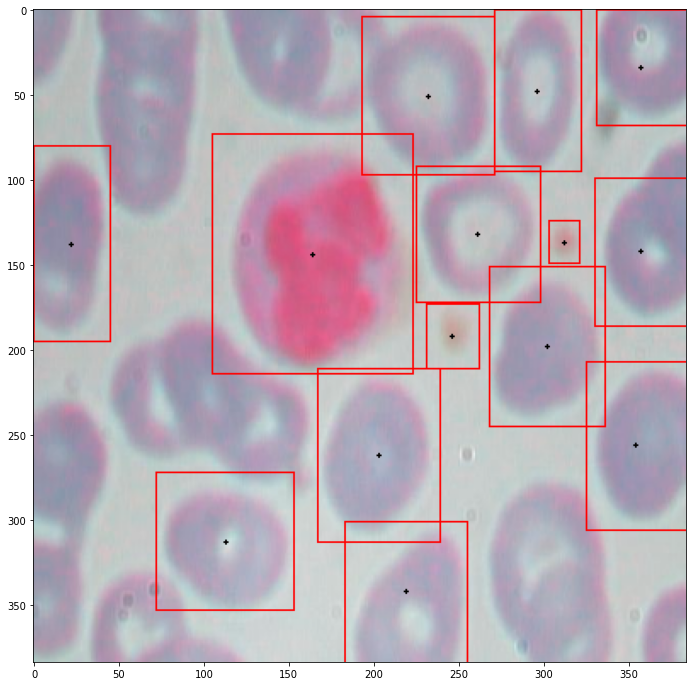

In [21]:
i = np.random.randint(len(images))

img = images[i].copy()
dat = data[i]

for d in dat.boxes:
    img = cv2.rectangle(
                    img,
                    (int(d.xmin*IMG_SIZE),int(d.ymin*IMG_SIZE)),
                    (int(d.xmax*IMG_SIZE),int(d.ymax*IMG_SIZE)),
                    (255,0,0),
                    1
                )
    
    img = cv2.circle(
                    img,
                    (int(d.x*IMG_SIZE),int(d.y*IMG_SIZE)),
                    1,
                    (0,0,0),
                    -1
                )

plt.figure(figsize=(12,12
                   ))
plt.imshow(img)

In [22]:
class BoxGrid(object):
    """
    Encodes Box
    """
    def __init__(self,low,high):
        self.low = low
        self.high = high
        self.repr = f"""
BoxGrid(
    low={self.low},
    high={self.high}
)
        """
    
    def __repr__(self):
        return self.repr
    
    def encode(self,h,w):
        return h/self.high,w/self.high
    
    def get_pair(self,y,x,h,w):
        h = int(h*self.high)
        w = int(w*self.high)
        return (x - (h//2),y - (h//2)),(x + (h//2),y + (h//2))
    
    def decode(self,):
        pass
    
    def encodeBatch(self,):
        pass
    
    def decodeBatch(self,):
        pass

In [103]:
class AnchorGrid(object):
    
    def __init__(self,resize_factor,k,image_size,box_gen):
        
        self.k = k
        self.resize_factor = resize_factor
        self.image_size = image_size
        self.grid_size = image_size // resize_factor
        self.box_gen = BoxGrid(**box_gen)
        self.length = self.grid_size*self.grid_size*self.k
        
        
        self.repr = f"""
AnchorGrid (
    resize_factor={self.resize_factor},
    k={self.k},
    image_size={self.image_size},
    grid_size={self.grid_size}
)"""
        
    def __repr__(self,):
        return self.repr
                
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        box = np.zeros((self.grid_size,self.grid_size,self.k,4))
        prob_0 = np.zeros((self.grid_size,self.grid_size,self.k,1))
        prob_1 = np.ones((self.grid_size,self.grid_size,self.k,1))
        prob = np.concatenate((prob_1,prob_0),axis=3)        
        
        data = data[np.logical_and(np.all(data[:,2:] <= self.box_gen.high,axis=1), np.any(data[:,2:] > self.box_gen.low,axis=1))]
        _counter = Counter()

        for y,x,h,w in data:
            Ox = int(x // self.resize_factor) 
            Oy = int(y // self.resize_factor) 

            if Ox == self.grid_size or Oy == self.grid_size:
                continue

            x = (x - (Ox*self.resize_factor)) / self.resize_factor
            y = (y - (Oy*self.resize_factor)) / self.resize_factor
            
            h,w = self.box_gen.encode(h,w)
                        
            Oi = _counter[f"{Oy}x{Ox}"]
            
            box[Oy,Ox,Oi,:] = [y,x,h,w]
            prob[Oy,Ox,Oi,:] = [0,1]
            
            _counter[f"{Oy}x{Ox}"] += 1

        prob,box =  prob.reshape(-1,self.k,2),box.reshape(-1,self.k,4)
        return prob.reshape(-1,2),box.reshape(-1,4)
    
    def encode(self,data):
        return self.__call__(data)
    
    def decode(self,prob,boxes,thresh=0.9):
        prob = prob.reshape(-1,self.k,1).reshape(self.grid_size,self.grid_size,self.k).copy()
        boxes = boxes.reshape(-1,self.k,4).reshape(self.grid_size,self.grid_size,self.k,4).copy()
        
        mask = prob > thresh
                        
        boxes[:,:,:,:2] = ((boxes[:,:,:,:2] * self.resize_factor) + self.grid_decode).astype(int) - (self.resize_factor // 2)
        boxes = boxes[mask]
        boxes[:,2:] = boxes[:,2:] * self.box_gen.high
        
        return boxes.astype(int)
        
    def generate(self,ret=False):
        xx,yy = np.meshgrid(np.arange(self.grid_size),np.arange(self.grid_size))
        xx,yy = np.reshape(xx,(self.grid_size,self.grid_size,1)),np.reshape(yy,(self.grid_size,self.grid_size,1))
        
        self.reference = np.concatenate((yy,xx),axis=-1)
        self.grid = self.reference.copy() * self.resize_factor
        self.grid += self.resize_factor // 2
        self.grid_decode = self.grid.copy().reshape(self.grid_size,self.grid_size,1,2).repeat(self.k,axis=2)
        
        if ret:
            return self.grid.copy(),self.reference.copy()
    

In [104]:
class AnchorLayer(object):
    """
    Encode Various Sizes Of FPNS
    """
    
    def __init__(self,img_size,config,):
        self.img_size = img_size
        self.config = config
        
        for cfg in config:
            self.__dict__[f"ANCHOR_{cfg['name']}"] = AnchorGrid(**cfg['anchor_grid'])
            self.__dict__[f"ANCHOR_{cfg['name']}"].generate()
        
        self.ANCHORS = [i for (i,j) in self.__dict__.items() if "ANCHOR_" in i]
        
    def __repr__(self,):
        return self.config.__repr__()
    
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        boxt = np.round(np.array([[b.y,b.x,b.h,b.w] for b in data.boxes])*self.img_size).astype(np.float32)
        boxt = pd.DataFrame(boxt,columns=['y','x','h','w']).sort_values(by=['y','x','h','w']).values

        prob,box = [],[]
        
        for anchor in self.ANCHORS:
            p,b = self.__dict__[anchor](boxt)
            prob.append(p)
            box.append(b)
            
        prob = np.concatenate(prob,axis=0)
        box = np.concatenate(box,axis=0)
            
        return prob,box
    
    def encode(self,data):
        return self.__call__(data)
    
    def decode(self,prob,boxes,thresh=0.9):
        prob = prob.reshape(-1,2).argmax(axis=1)
        boxes = boxes.reshape(-1,4)
        
        last = 0
        ret_boxes = []
        for anchor in self.ANCHORS:
            index = self.__dict__[anchor].length
            batch_ = (prob[last:last+index].copy(),boxes[last:last+index].copy())
            batch = self.__dict__[anchor].decode(*batch_,thresh=thresh)
            last = last+index
            ret_boxes.append(batch)
                       
        return np.concatenate(ret_boxes,axis=0).astype(np.uint32)

In [105]:
anchor_config = {
    "img_size":IMG_SIZE,
    "config":[
        {
            "anchor_grid":{
                "resize_factor":32,
                "k":3,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":8,
                    "high":64
                }
            },
            "name":"FPN0"
        },
        {
            "anchor_grid":{
                "resize_factor":64,
                "k":4,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":64,
                    "high":128
                }
            },
            "name":"FPN1"
        },
        {
            "anchor_grid":{
                "resize_factor":128,
                "k":3,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":128,
                    "high":256
                }
            },
            "name":"FPN2"
        }
    ]
}

In [106]:
anchors = AnchorLayer(**anchor_config)
prob_,box_ = anchors(data[i])

In [107]:
anchors.ANCHOR_FPN1.length

144

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


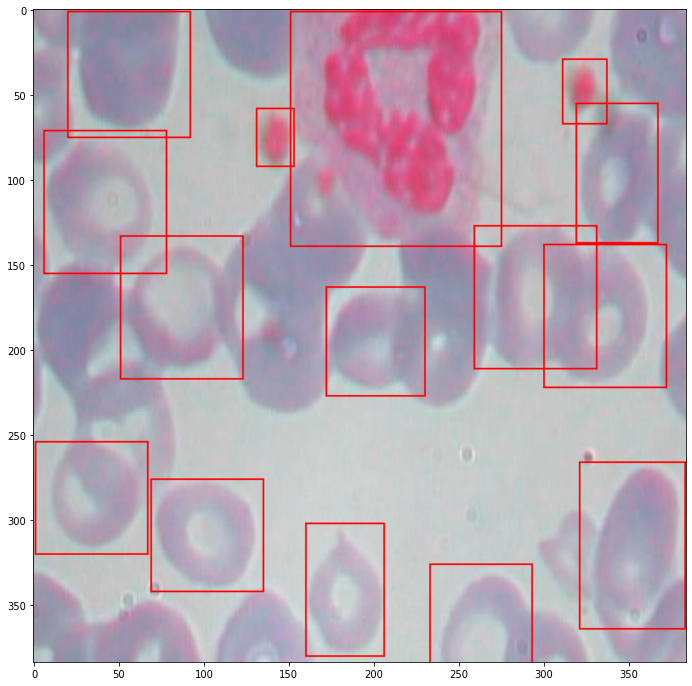

In [108]:
i = np.random.randint(0,len(images))

img = images[i].copy()
prob_,box_ = anchors(data[i])
decoded = anchors.decode(prob_,box_)

for y,x,h,w in decoded:
    img = cv2.rectangle(img,(x-(w//2),y-(h//2)),(x+(w//2),y+(h//2)),(255,0,0),1)

plt.figure(figsize=(12,12))
plt.imshow(img)

In [109]:
y_prob,y_box = [],[]


for d in data:
    p,b = anchors(d)
    y_prob.append(p)
    y_box.append(b)
    
y_prob,y_box = np.array(y_prob),np.array(y_box)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


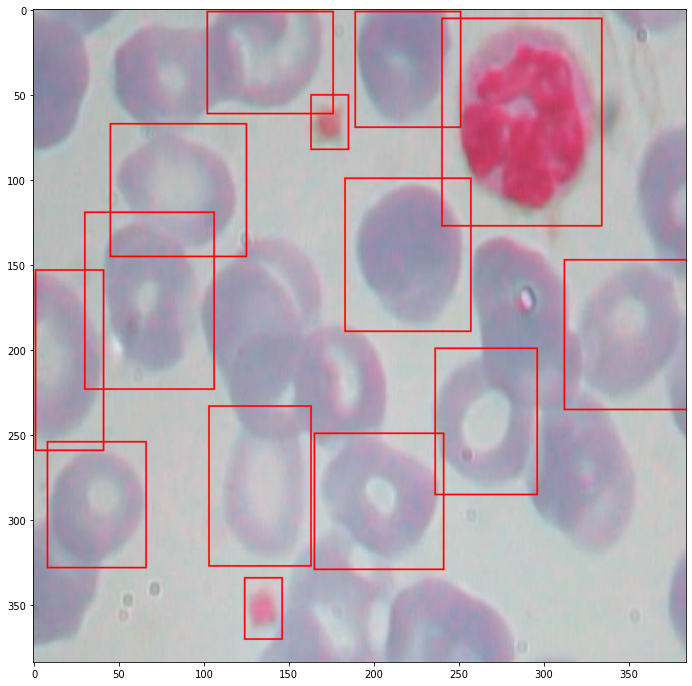

In [110]:
i = np.random.randint(0,len(images))

img = images[i].copy()
prob_ = y_prob[i].copy()
box_ = y_box[i].copy()

decoded = anchors.decode(prob_,box_)


for y,x,h,w in decoded:
    img = cv2.rectangle(img,(x-(w//2),y-(h//2)),(x+(w//2),y+(h//2)),(255,0,0),1)

fig = plt.figure(figsize=(12,12))
plt.imshow(img)

In [81]:
test_index = set(np.random.randint(0,len(images),(68,)))
train_index = set(np.arange(0,len(images)))

train_index = list(train_index.difference(test_index))
test_index = list(test_index)

len(train_index),len(test_index)

(300, 64)

In [82]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback,ReduceLROnPlateau

In [130]:
_inp = Input(shape=(IMG_SIZE,IMG_SIZE,3))


def block(_in,filters,ksize,name,pool=False):
    aconv0 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"{name}_conv0")(_in)
    aconv1 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"{name}_conv1")(aconv0)
    aconv2 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"{name}_conv2")(aconv1)
    aconv3 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"{name}_conv3")(aconv2)
    aout = BatchNormalization(name=f"{name}_norm")(concatenate([aconv0,aconv1,aconv2,aconv3],name=f"{name}_conc"))
    
    if pool:
        aout = MaxPool2D(name=f"{name}_pool")(aout)
    return aout


def out(_in,k,name):
    prob = Conv2D(k*2,1,padding="same",name=f"prob_conv_{name}")(_in)
    prob = BatchNormalization(name=f"prob_norm_{name}")(prob)
    prob = Activation("sigmoid",name=f"prob_out_{name}")(prob)
    prob = Reshape((-1,2),name=f"{name}_prob")(prob)

    box = Conv2D(k*4,1,padding="same",name=f"box_conv_{name}")(_in)
    box = BatchNormalization(name=f"box_batch_{name}")(box)
    box = Activation("sigmoid",name=f"box_out_{name}")(box)
    box = Reshape((-1,4),name=f"{name}_box")(box)
    
    return prob,box

a = block(_inp,32,5,name="a",pool=True)
b = block(a,32,3,name="b",pool=True)
c = block(b,32,3,name="c",pool=True)
d = block(c,32,3,name="d",pool=True)


fpn0  = block(filters=64,ksize=3,_in=d,pool=True,name="FPN0") ### 12x12x256
(prob_0,box_0) = out(fpn0,3,"fpn0")

fpn1  = block(filters=256,ksize=3,_in=fpn0,pool=True,name="FPN1") ### 6x6x1024
(prob_1,box_1) = out(fpn1,4,"fpn1")

fpn2  = block(filters=1024,ksize=3,_in=fpn1,pool=True,name="FPN2") ### 3x3x4096
(prob_2,box_2) = out(fpn2,3,"fpn2")

prob_out = concatenate([prob_0,prob_1,prob_2],1,name="prob")
box_out = concatenate([box_0,box_1,box_2],1,name="box")

net = keras.Model(_inp,[prob_out,box_out])
prob_train = keras.Model(_inp,prob_out)

In [131]:
net.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
a_conv0 (Conv2D)                (None, 384, 384, 32) 2432        input_7[0][0]                    
__________________________________________________________________________________________________
a_conv1 (Conv2D)                (None, 384, 384, 32) 25632       a_conv0[0][0]                    
__________________________________________________________________________________________________
a_conv2 (Conv2D)                (None, 384, 384, 32) 25632       a_conv1[0][0]                    
___________________________________________________________________________________________

In [132]:
%%time

i = np.random.randint(0,len(images))
a = net(images[i:i+1])

CPU times: user 47.3 ms, sys: 0 ns, total: 47.3 ms
Wall time: 44.7 ms


In [133]:
p,b = a

In [134]:
p.shape,b.shape

(TensorShape([1, 603, 2]), TensorShape([1, 603, 4]))

In [135]:
y_prob.shape

(364, 603, 2)

In [136]:
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

In [137]:
class BoxLoss(tf.Module):
    """
    BoxLoss
    """
    def __init__(self,):
        self.__name__="BoxLoss"
        self.zero = tf.constant(0,tf.float32)
        self.one = tf.constant(1,tf.float32)
        self.two = tf.constant(2,tf.float32)
        self.l2_loss = tf.keras.losses.MeanSquaredError()

        self.slice_y = {"begin":[0,0,0],"size":[-1,-1,1]}
        self.slice_x = {"begin":[0,0,1],"size":[-1,-1,1]}
        self.slice_h = {"begin":[0,0,2],"size":[-1,-1,1]}
        self.slice_w = {"begin":[0,0,3],"size":[-1,-1,1]}
        
        self.repr = f"""
BoxLoss(
    
)
        """
        
    def __repr__(self,):
        return self.repr

    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        
        y = tf.slice(y_true,**self.slice_y)
        x = tf.slice(y_true,**self.slice_x)

        mask = tf.logical_or(tf.greater(y,self.zero),tf.greater(x,self.zero))

        y = y[mask] 
        x = x[mask] 
        h = tf.slice(y_true,**self.slice_h)[mask] 
        w = tf.slice(y_true,**self.slice_w)[mask] 

        y_ = tf.slice(y_pred,**self.slice_y)[mask] 
        x_ = tf.slice(y_pred,**self.slice_x)[mask] 
        h_ = tf.slice(y_pred,**self.slice_h)[mask] 
        w_ = tf.slice(y_pred,**self.slice_w)[mask] 
        
        w2  = tf.divide(w,self.two)
        h2  = tf.divide(h,self.two)
        w2_  = tf.divide(w_,self.two)
        h2_  = tf.divide(h_,self.two)
        
        xmin = tf.subtract(x,w2)
        xmax = tf.add(x,w2)
        ymin = tf.subtract(y,h2)
        ymax = tf.add(y,h2)
        
        xmin_ = tf.subtract(x_,w2_)
        xmax_ = tf.add(x_,w2_)
        ymin_ = tf.subtract(y_,h2_)
        ymax_ = tf.add(y_,h2_)
        
        Cymin = tf.maximum(ymin,ymin_)
        Cymax = tf.minimum(ymax,ymax_)
        Cxmin = tf.maximum(xmin,xmin_)
        Cxmax = tf.minimum(xmax,xmax_)

        Ch = tf.subtract(Cymax , Cymin)
        Cw = tf.subtract(Cxmax , Cxmin)
        
        Aa = tf.multiply( h , w )
        Ba = tf.multiply( h_ , w_ )
        Ca = tf.multiply( Cw , Ch )
        
        IoU = tf.reduce_mean(tf.subtract(self.one,tf.divide(Ca,tf.subtract(tf.add(Aa,Ba),Ca))))
        Xl2 = self.l2_loss(x,x_)
        Yl2 = self.l2_loss(y,y_)
        
        return Xl2 + Yl2 + IoU

In [138]:
boxloss = BoxLoss()

In [139]:
def schedule(epoch):
    if epoch > 100:
        return .000001
    elif epoch > 70:
        return .00001
    elif epoch > 10:
        return .0001
    else:
        return .001
    
lrs = LearningRateScheduler(schedule=schedule,verbose=1)

In [140]:
chk = ModelCheckpoint(filepath="./checkpoints/net",save_weights_only=True,monitor='loss')

In [141]:
opt = keras.optimizers.Adam()

In [142]:
def flow(epochs,index):
    for epoch in range(epochs):
        for i in train_index:
            yield images[i:i+1],(y_prob[i:i+1],y_box[i:i+1])

In [143]:
train_flow = flow(120,train_index)

In [144]:
net.compile(optimizer=opt,loss={"prob":binary_crossentropy,"box":boxloss})

In [145]:
net.fit_generator(train_flow,steps_per_epoch=len(train_index),epochs=120,callbacks=[chk,lrs])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/120
300/300 [==============================] - 35s 117ms/step - loss: 1.4739 - prob_loss: 0.6752 - box_loss: 0.7987 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/120
300/300 [==============================] - 34s 113ms/step - loss: 1.1491 - prob_loss: 0.5287 - box_loss: 0.6204 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/120
300/300 [==============================] - 33s 111ms/step - loss: 0.9924 - prob_loss: 0.4275 - box_loss: 0.5649 - lr: 0.0010

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/120
300/300 [==============================] - 33s 109ms/step - loss: 0.8728 - prob_loss: 0.3487 - box_loss: 0.5241 - lr: 0.0010

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/120
300/300 [==============================] - 33s 109ms/step - loss: 0.7846 - prob_loss: 0.2887 - 


Epoch 00040: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 40/120
300/300 [==============================] - 33s 111ms/step - loss: 0.1972 - prob_loss: 0.0627 - box_loss: 0.1345 - lr: 1.0000e-04

Epoch 00041: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 41/120
300/300 [==============================] - 33s 109ms/step - loss: 0.1930 - prob_loss: 0.0614 - box_loss: 0.1316 - lr: 1.0000e-04

Epoch 00042: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 42/120
300/300 [==============================] - 33s 109ms/step - loss: 0.1898 - prob_loss: 0.0600 - box_loss: 0.1298 - lr: 1.0000e-04

Epoch 00043: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 43/120
300/300 [==============================] - 33s 109ms/step - loss: 0.1868 - prob_loss: 0.0588 - box_loss: 0.1280 - lr: 1.0000e-04

Epoch 00044: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 44/120
300/300 [==============================] - 33s 109ms/step - loss: 0.1

300/300 [==============================] - 33s 108ms/step - loss: 0.0933 - prob_loss: 0.0318 - box_loss: 0.0614 - lr: 1.0000e-05

Epoch 00079: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 79/120
300/300 [==============================] - 32s 108ms/step - loss: 0.0902 - prob_loss: 0.0317 - box_loss: 0.0585 - lr: 1.0000e-05

Epoch 00080: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 80/120
300/300 [==============================] - 32s 108ms/step - loss: 0.0877 - prob_loss: 0.0317 - box_loss: 0.0560 - lr: 1.0000e-05

Epoch 00081: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 81/120
300/300 [==============================] - 32s 108ms/step - loss: 0.0855 - prob_loss: 0.0316 - box_loss: 0.0539 - lr: 1.0000e-05

Epoch 00082: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 82/120
300/300 [==============================] - 32s 108ms/step - loss: 0.0833 - prob_loss: 0.0315 - box_loss: 0.0518 - lr: 1.0000e-05

Epoch 00083: LearningRateS

300/300 [==============================] - 33s 109ms/step - loss: 0.0687 - prob_loss: 0.0301 - box_loss: 0.0386 - lr: 1.0000e-06

Epoch 00117: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 117/120
300/300 [==============================] - 33s 110ms/step - loss: 0.0684 - prob_loss: 0.0301 - box_loss: 0.0383 - lr: 1.0000e-06

Epoch 00118: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 118/120
300/300 [==============================] - 33s 109ms/step - loss: 0.0682 - prob_loss: 0.0301 - box_loss: 0.0380 - lr: 1.0000e-06

Epoch 00119: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 119/120
300/300 [==============================] - 33s 109ms/step - loss: 0.0679 - prob_loss: 0.0301 - box_loss: 0.0378 - lr: 1.0000e-06

Epoch 00120: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 120/120
300/300 [==============================] - 33s 110ms/step - loss: 0.0677 - prob_loss: 0.0301 - box_loss: 0.0376 - lr: 1.0000e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


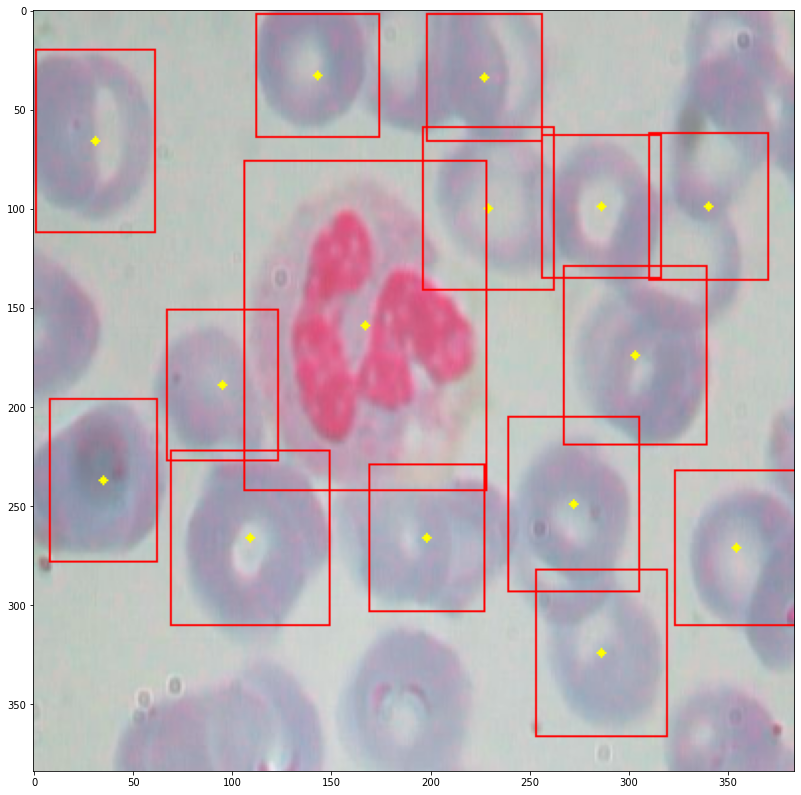

In [152]:
i = np.random.choice(test_index)
img = images[i].copy()
pa,ba = net.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
pa = prob_train.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
decoded = anchors.decode(pa,ba,thresh=0.5)

for y,x,h,w in decoded:
    xmin,ymin,xmax,ymax = x - (w//2),y - (h//2),x + (w//2),y + (h//2)
    img = cv2.circle(img,(x,y),2,(255,255,0),-1)
    img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),1)    

plt.figure(figsize=(14,14))
plt.imshow(img)